# Imports

* Será utilizado a biblioteca Keras para o desenvolvimento do modelo de classificação.

* A bilioteca Pandas será utilizado para manipular os dados

In [2]:
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

2023-09-16 17:26:20.437413: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 17:26:21.083185: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Leitura e Preprocessamento dos Dados

O dataset escolhido foi o [FER-2013](https://www.kaggle.com/datasets/msambare/fer2013) disponível no Kaggle. O dataset constitue-se de imagens de 48x48 pixels em escala de cinza representando expressões faciais humanas em 7 classes rotuladas, sendo elas: Angry, Disgust, Fear, Happy, Sad, Surprise e Neutral.

In [3]:
# Definição de parâmetros
train_dir = '../data/fear2013/csv/train_pixels_data.csv'
valid_dir = '../data/fear2013/csv/test_pixels_data.csv'
image_size = (48, 48)
color_mode = 'grayscale'

In [4]:
def read_dataset(path):
    data = pd.read_csv(
        path,
    )
    return data

In [5]:
#Letirua conjunto de treino e validação
df_train = read_dataset(train_dir)
df_valid = read_dataset(valid_dir) 

# Separando featues e labels
x_train = df_train.iloc[:, 1:].values
y_train = df_train['label']

x_valid = df_valid.iloc[:, 1:].values
y_valid = df_valid['label']

# Normalizando as features entre 0 e 1
x_train = x_train / x_train.max()
x_valid = x_valid / x_valid.max()

# Transformando as labels em one-hot-encoding
num_classes = y_train.nunique()
classes = y_train.unique()
y_train = pd.get_dummies(y_train, dtype='uint8').values
y_valid = pd.get_dummies(y_valid, dtype='uint8').values

# Formatando as features para imagem

* Para utilizar CNN utilizaremos a representação em formato tridimensional (altura, largura, canais de cores) de imagens

In [6]:
x_train.shape, x_valid.shape

((28709, 2304), (7178, 2304))

In [7]:
x_train = x_train.reshape(-1, 48, 48, 1)
x_valid = x_valid.reshape(-1, 48, 48, 1)

* Cada imagem sendo representada por uma matriz 48x48 com 1 canal (cinza)

In [8]:
x_train.shape, x_valid.shape

((28709, 48, 48, 1), (7178, 48, 48, 1))

# Construindo o modelo CNN

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

# É construido um modelo de CNN com 3 camadas convolucionais, 3 camadas de pooling, 2 camadas densas e 2 camadas de dropout.
model = Sequential()
# Camada de entrada seguida de convolução por 75 filtros de tamanho 3x3
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu",
                 input_shape=(48, 48, 1)))
# Realizada normalização dos dados no Batch.
model.add(BatchNormalization())
# camada de max pooling de tamanho 2x2
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
# Camada de convolução por 50 filtros de tamanho 3x3
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
# Camada de dropout de 20%
model.add(Dropout(0.2))
# Novamente normalização dos dados no Batch.
model.add(BatchNormalization())
# Camada de max pooling de tamanho 2x2
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
# Camada de convolução por 25 filtros de tamanho 3x3
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
# Novamente normalização dos dados no Batch.
model.add(BatchNormalization())
# Camada de max pooling de tamanho 2x2
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
# Camada flatten para transformar os dados em um vetor unidimensional
model.add(Flatten())
# Camada densa de 512 neurônios
model.add(Dense(units=512, activation="relu"))
# Camada de dropout de 30%
model.add(Dropout(0.3))
# Camada de saída com 7 neurônios para as 7 classes, aplicado a função de ativação softmax
model.add(Dense(units=num_classes, activation="softmax"))

2023-09-16 17:26:26.875993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-16 17:26:26.898177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-16 17:26:26.898414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

* Visualizando o modelo criado

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 75)        750       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 75)        300       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 75)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 24, 24, 50)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 50)        2

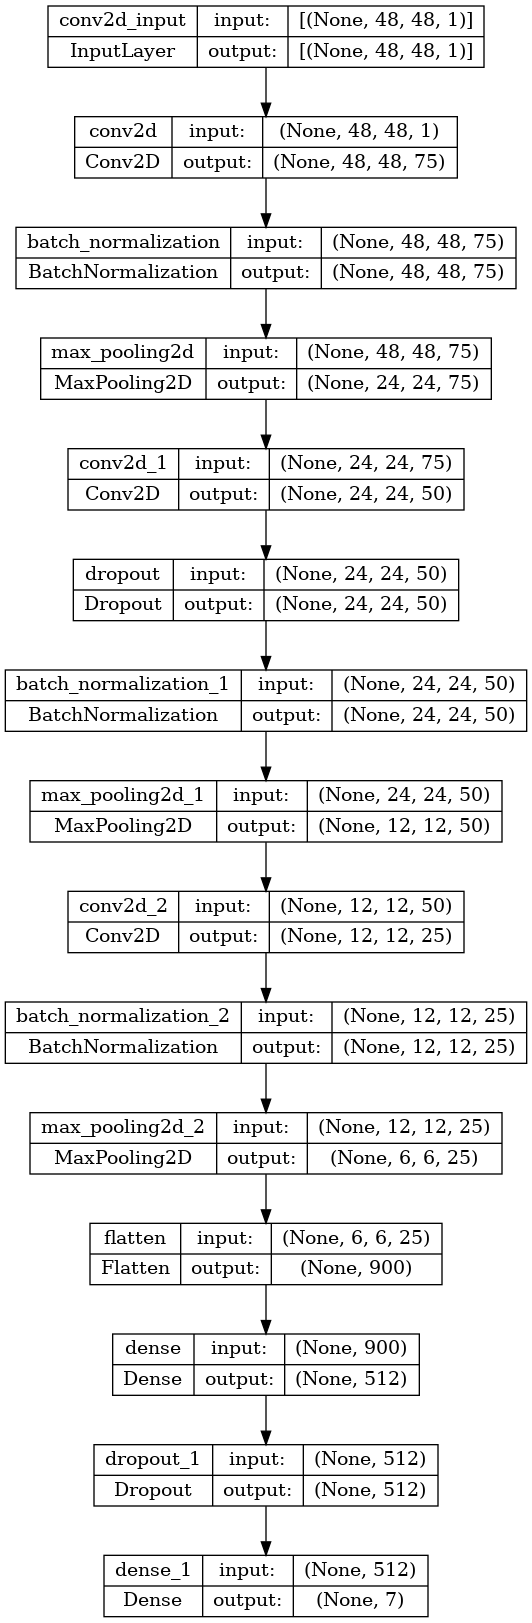

In [10]:
keras.utils.plot_model(model, show_shapes=True)

* Compilando o modelo, utilizando a função de perda categorical_crossentropy, otimizador Adam e métrica de acurácia.

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinamento

In [12]:
# Treinamento do modelo por 100 épocas
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=100, verbose=1)

Epoch 1/100


2023-09-16 12:50:48.802980: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-09-16 12:50:50.562587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-16 12:50:52.099873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-16 12:50:52.108735: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1d54011c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-16 12:50:52.108748: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-09-16 12:50:52.113988: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_uti

898/898 [==============================] - 10s 5ms/step - loss: 1.6377 - accuracy: 0.3703 - val_loss: 1.5879 - val_accuracy: 0.3877
Epoch 2/100
898/898 [==============================] - 4s 4ms/step - loss: 1.3651 - accuracy: 0.4757 - val_loss: 1.4347 - val_accuracy: 0.4537
Epoch 3/100
898/898 [==============================] - 4s 4ms/step - loss: 1.2398 - accuracy: 0.5272 - val_loss: 1.3033 - val_accuracy: 0.5056
Epoch 4/100
898/898 [==============================] - 4s 4ms/step - loss: 1.1402 - accuracy: 0.5679 - val_loss: 1.3631 - val_accuracy: 0.4908
Epoch 5/100
898/898 [==============================] - 4s 4ms/step - loss: 1.0368 - accuracy: 0.6087 - val_loss: 1.2174 - val_accuracy: 0.5465
Epoch 6/100
898/898 [==============================] - 4s 4ms/step - loss: 0.9303 - accuracy: 0.6548 - val_loss: 1.1874 - val_accuracy: 0.5548
Epoch 7/100
898/898 [==============================] - 4s 4ms/step - loss: 0.8177 - accuracy: 0.7001 - val_loss: 1.2296 - val_accuracy: 0.5676
Epoch 8/10

# Avaliação

## Matriz de confusão

* Predição do modelo do label do conjunto de validação

In [13]:
# é feito argmax para pegar o índice que identifica a classe com maior probabilidade de ser a classe real segundo o modelo.
y_valid_pred = model.predict(x_valid).argmax(axis=1)

225/225 [==============================] - 0s 888us/step


* Criado a matriz de confusão para avaliar o modelo no conjunto de validação

In [14]:
cm = confusion_matrix(y_valid.argmax(axis=1), y_valid_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=classes)

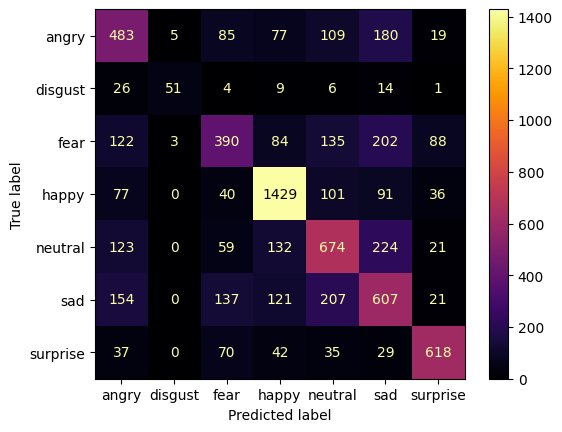

In [17]:
disp.plot(cmap='inferno')

## Métricas de avaliação: Acurácia, Precisão, Recall e F1-Score

* Print das métricas de avaliação

In [18]:
print(classification_report(y_valid.argmax(axis=1), y_valid_pred, target_names=classes))

              precision    recall  f1-score   support

       angry       0.47      0.50      0.49       958
     disgust       0.86      0.46      0.60       111
        fear       0.50      0.38      0.43      1024
       happy       0.75      0.81      0.78      1774
     neutral       0.53      0.55      0.54      1233
         sad       0.45      0.49      0.47      1247
    surprise       0.77      0.74      0.76       831

    accuracy                           0.59      7178
   macro avg       0.62      0.56      0.58      7178
weighted avg       0.59      0.59      0.59      7178



## Comentários Avaliação

Ao adotar uma abordagem de Deep Learning com uma Rede Neural Convolucional (CNN) e diversas camadas ocultas, conseguimos superar o problema de underfitting observado anteriormente. O modelo apresentou uma excelente performance no conjunto de treino, atingindo uma acurácia próxima de 98%. No entanto, no conjunto de validação, a acurácia caiu para 59%. Esse desempenho sugere que o modelo pode estar sofrendo de overfitting. Para aprimorar ainda mais o modelo, algumas recomendações incluem:

* Empregar data augmentation para aumentar a variabilidade das imagens no conjunto de treino, tornando o aprendizado mais desafiador.
* Aplicar regularizações L1 e L2 para minimizar o risco de overfitting.


Comparando com a abordagem de Machine Learning (ML) anterior, notamos que o modelo baseado em CNN é mais complexo e capaz de mapear os padrões do conjunto de treino de forma mais eficaz. No entanto, isso vem ao custo de um aumento no custo computacional, já que há mais parâmetros a serem treinados, resultando em um tempo de treinamento maior. A abordagem com CNN superou o método ML no conjunto de validação, alcançando 59% de acurácia em comparação aos 36% obtidos pela abordagem ML.